<a href="https://colab.research.google.com/github/nupursjsu/Deep-Learning/blob/master/Graded_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label prediction with Planet Amazon dataset using Keras and with Tensorboard integration

Following is the Kaggle link to Planet Amazon dataset

[Planet Amazon dataset link](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data)

## Importing necessary libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import zipfile
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
# Clear any logs from previous runs
!rm -rf ./logs/

Using TensorFlow backend.


In [0]:
np.random.seed(1)

##Loading datasets

In [0]:
#Code to read files into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Downloading the train images folder from drive
link = 'https://drive.google.com/open?id=1o-PCjSNWGJ5VIdgkZEyWcC24kaK47BiY'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train-jpg.zip')

#Unziping the folder
with zipfile.ZipFile('train-jpg.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [0]:
#Downloading the test images folder from drive
link = 'https://drive.google.com/open?id=1UQRPhQeTiTKhRKEyXUXTBtNsNb6GQU1d'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test-jpg.zip')

#Unziping the folder
with zipfile.ZipFile('test-jpg.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [0]:
#Downloading the train csv file which contains image names and labels
link = 'https://drive.google.com/open?id=1qO-8eRFEiXK9RG6G6Xd5gVHa70zN_Ami'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train-v2.csv')

In [0]:
#Downloading the test csv file which contains image names and labels
link = 'https://drive.google.com/open?id=1rcm_3sOELQSmxUy0YbmArqnv-hcdOHKA'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test-v2.csv')

In [0]:
#Loading train and test dataset into pandas dataframe
train_data = pd.read_csv('train-v2.csv')
test_data = pd.read_csv('test-v2.csv')

In [9]:
#Displaying first few records in train data
train_data.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [10]:
#Displaying all unique labels
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_data['tags'].values]))
labels_set = set(labels_list)
label_map = {l: i for i, l in enumerate(labels_set)}
print(label_map)

{'agriculture': 0, 'conventional_mine': 1, 'bare_ground': 2, 'partly_cloudy': 3, 'cultivation': 4, 'clear': 5, 'cloudy': 6, 'slash_burn': 7, 'selective_logging': 8, 'road': 9, 'primary': 10, 'habitation': 11, 'blooming': 12, 'blow_down': 13, 'water': 14, 'haze': 15, 'artisinal_mine': 16}


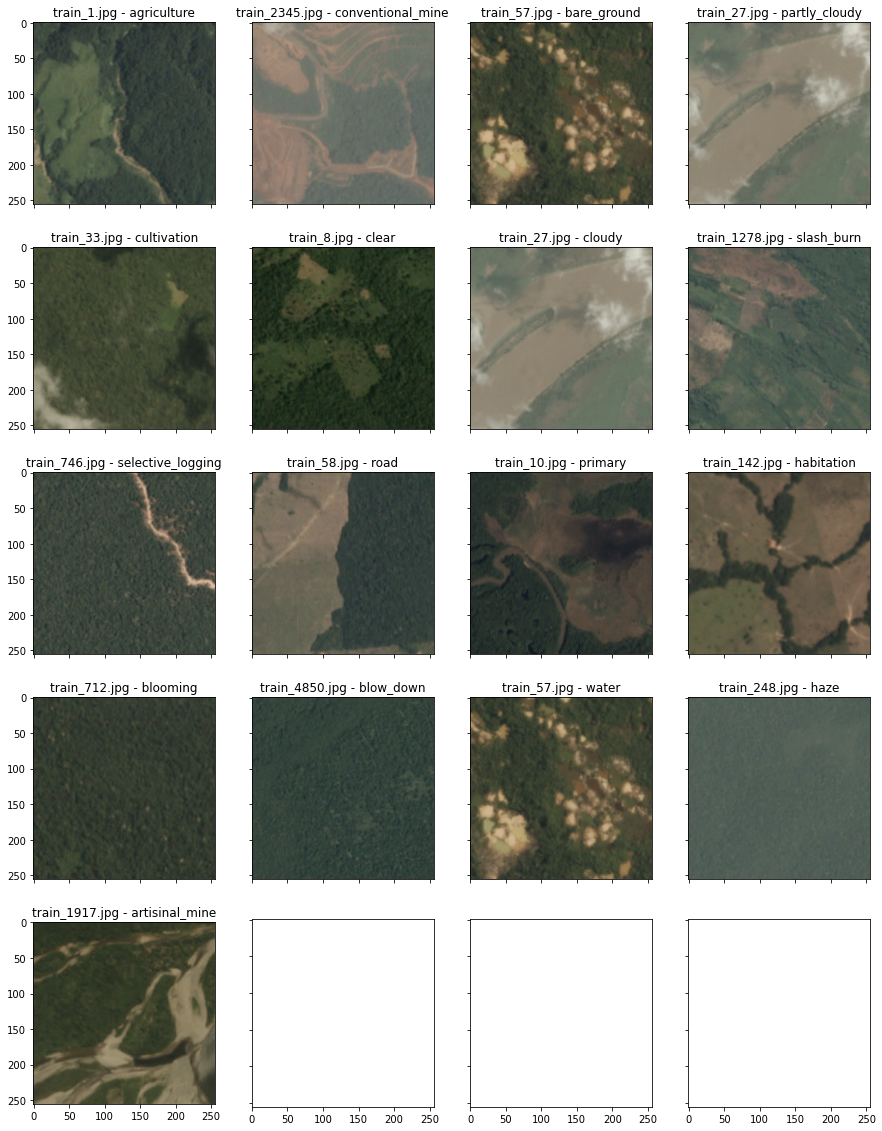

In [11]:
#Displaying 17 images with their labels to see what kind of images we are dealing with
images_title = [train_data[train_data['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread('train-jpg/' + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

In [12]:
#Getting train images and their corresponding labels as numpy arrays 
train_images = []
train_labels = []

for i, labels in tqdm(train_data.values, miniters=6000):
    image = cv2.imread('train-jpg/{}.jpg'.format(i))
    targets = np.zeros(17)
    for j in labels.split(' '):
        targets[label_map[j]] = 1 
    train_images.append(cv2.resize(image, (32, 32)))
    train_labels.append(targets)
    
train_labels = np.array(train_labels, np.uint8)
train_images = np.array(train_images, np.float16) / 255.   #Normalizing train images

100%|██████████| 40479/40479 [00:46<00:00, 863.74it/s]


In [13]:
#Getting test images and their corresponding labels as numpy arrays 
test_images= []
test_labels = []

for i, labels in tqdm(test_data.values, miniters=6000):
    try:
      image = cv2.imread('test-jpg/{}.jpg'.format(i))
      targets = np.zeros(17)
      for j in labels.split(' '):
        targets[label_map[j]] = 1 
      test_images.append(cv2.resize(image, (32, 32)))
      test_labels.append(targets)
    except:
      continue
    
test_labels = np.array(test_labels, np.uint8)
test_images = np.array(test_images, np.float16) / 255.  #Normalizing test images

100%|██████████| 61191/61191 [00:48<00:00, 1268.00it/s]


In [14]:
#Splitting train dataset into train and validation datasets
trainvalSplit = 32000
train_images, val_images, train_labels, val_labels = train_images[:trainvalSplit], train_images[trainvalSplit:], train_labels[:trainvalSplit], train_labels[trainvalSplit:]
print(train_images.shape, val_images.shape, train_labels.shape, val_labels.shape)

(32000, 32, 32, 3) (8479, 32, 32, 3) (32000, 17) (8479, 17)


In [0]:
#Importing necessary libraries to build CNN model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization

In [0]:
#Creating CNN
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation = 'sigmoid'))

In [0]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [18]:
#Displaying model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [19]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#Fitting the model
model.fit(train_images, train_labels, batch_size = 10, epochs = 5, verbose = 1, validation_data=(val_images, val_labels), callbacks=[tensorboard_callback])

Train on 32000 samples, validate on 8479 samples
Epoch 1/5
32000/32000 [==============================] - 28s 877us/step - loss: 0.1938 - accuracy: 0.9244 - val_loss: 0.1769 - val_accuracy: 0.9330
Epoch 2/5
32000/32000 [==============================] - 22s 673us/step - loss: 0.1645 - accuracy: 0.9342 - val_loss: 0.2304 - val_accuracy: 0.9231
Epoch 3/5
32000/32000 [==============================] - 22s 682us/step - loss: 0.1566 - accuracy: 0.9374 - val_loss: 0.1995 - val_accuracy: 0.9192
Epoch 4/5
32000/32000 [==============================] - 22s 673us/step - loss: 0.1515 - accuracy: 0.9395 - val_loss: 0.1628 - val_accuracy: 0.9351
Epoch 5/5
32000/32000 [==============================] - 22s 682us/step - loss: 0.1466 - accuracy: 0.9411 - val_loss: 0.1506 - val_accuracy: 0.9403


In [20]:
#Evaluating the model
_,train_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print('Train: %.3f' % (train_accuracy*100))

Train: 82.286


In [21]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>